In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from tqdm import tqdm


In [2]:
def blackScholes(current_stock_price, strike_price, current_time, maturity_time, interest_rate, volatality, option_type = "call"):
    """
    Function to calculate the price of the option using Black Scholes model

    Args:
        current_stock_price : Current stock price
        strike_price : Strike price
        current_time : Current time
        maturity_time : Maturity time
        interest_rate :  Risk free interest rate
        volatality : Volatality of the stock

    Returns:
        Option_price : Price of the option at current time
        delta : Delta value of the option
    """
    
    tao = maturity_time - current_time
    d1 = (np.log(current_stock_price/strike_price) + (interest_rate + volatality**2/2) * tao)/(volatality*np.sqrt(tao))
    d2 = d1 - volatality * np.sqrt(tao)
    if option_type == "put":
        option_price =  - current_stock_price * norm.cdf(-d1) + np.exp(-interest_rate * tao) * strike_price * norm.cdf(-d2)
        delta = - norm.cdf(-d1)
    if option_type == "call":
        option_price = current_stock_price * norm.cdf(d1) - np.exp(-interest_rate * tao) * strike_price * norm.cdf(d2)
        delta = norm.cdf(d1)
    
    
    return option_price, delta 

In [3]:
def create_tridiagonal_matrix(main_diag_value, off_diag_value, size):
    """
    Create a tridiagonal matrix with specified values on the main diagonal and off-diagonals.
    
    Parameters:
        main_diag_value: Value of the main diagonal elements.
        off_diag_value: Value of the off-diagonal elements.
        size (int): Size of the square matrix.
    
    Returns:
        numpy.ndarray: Tridiagonal matrix.
    """
    # Create a zero-filled matrix of the specified size
    tridiag_matrix = np.zeros((size, size))
    
    # Fill the main diagonal
    np.fill_diagonal(tridiag_matrix, main_diag_value)
    
    # Fill the upper diagonal (above the main diagonal)
    np.fill_diagonal(tridiag_matrix[1:], off_diag_value[1])
    
    # Fill the lower diagonal (below the main diagonal)
    np.fill_diagonal(tridiag_matrix[:, 1:], off_diag_value[0])
    
    return tridiag_matrix

In [4]:
def euroOption_FTCS(delta_X, S0, K, vol, r, T, bump = 1):
    
    delta_T = delta_X ** 2 / 4
    N_T = int(T/delta_T)
    Smax = 3 * K
    Smin = K/3
    xmax = np.log(Smax)
    xmin = np.log(Smin)
    N = int((xmax - xmin) / delta_X) + 1
    x = np.linspace(xmin, xmax, N)
    
    initial_option_price = np.maximum(np.exp(x) - K, 0)
    
    a = 1 - vol**2 * delta_T / ( delta_X**2)  - r * delta_T                                     # main diagonal coefficient
    b = (r - 0.5 * vol**2) * delta_T / (2 * delta_X) + 0.5 * vol**2 * delta_T / (delta_X**2)    # upper diagonal coefficient
    c = - (r - 0.5 * vol**2) * delta_T / (2 * delta_X) + 0.5 * vol**2 * delta_T / (delta_X**2)  # lower diagonal coefficient
    
    dirichlet = np.zeros(N) 
    dirichlet[-1] = (np.exp(xmax) - K * np.exp(-r * T))
    band_mat = create_tridiagonal_matrix(a, [c, b], N)
    prev_sol = dirichlet * b + np.dot(band_mat, initial_option_price)
    
    for _ in range(N_T):
        next_sol = np.dot(band_mat, prev_sol) + dirichlet * b
        prev_sol = next_sol
    
    option_v = np.interp(np.log(S0), x, prev_sol)
    option_v_bump = np.interp(np.log(S0 + bump), x, prev_sol)
    delta = (option_v_bump - option_v) / bump
    
    return np.interp(np.log(S0), x, prev_sol), delta

In [5]:
deltaxs = [0.1, 0.05, 0.02, 0.01, 0.008, 0.006, 0.004, 0.002]
option_price1 = []
option_price2 = []
option_price3 = []
S0 = [100, 110, 120]
K = 110
T = 1.0
r = 0.04
sigma = 0.3
for delta_x in tqdm(deltaxs):
    y1, delta1 = euroOption_FTCS(delta_x, S0[0], K, vol=sigma, r=r, T=T)
    y2, delta_2 = euroOption_FTCS(delta_x, S0[1], K, vol=sigma, r=r, T=T)
    y3, delta_3 = euroOption_FTCS(delta_x, S0[2], K, vol=sigma, r=r, T=T)
    option_price1.append(y1)
    option_price2.append(y2)
    option_price3.append(y3)
Error1 = np.abs(np.array(option_price1) - blackScholes(S0[0], K, 0, T, r, sigma, option_type = "call")[0])
Error2 = np.abs(np.array(option_price2) - blackScholes(S0[1], K, 0, T, r, sigma, option_type = "call")[0])
Error3 = np.abs(np.array(option_price3) - blackScholes(S0[2], K, 0, T, r, sigma, option_type = "call")[0])

100%|██████████| 8/8 [13:39<00:00, 102.46s/it]


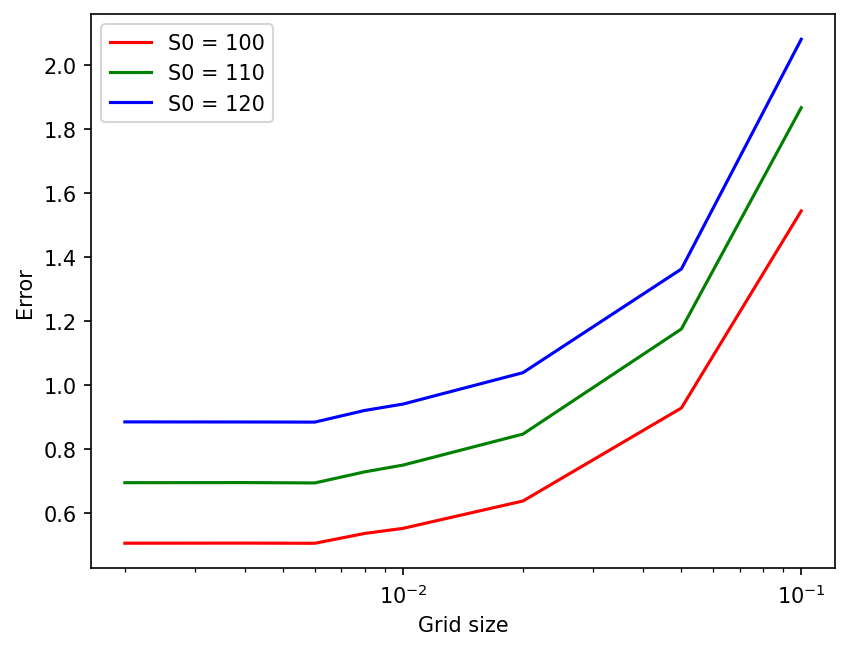

In [6]:
plt.figure(dpi=150)
plt.plot(deltaxs, Error1, label = "S0 = 100", color = 'r')
plt.plot(deltaxs, Error2, label = "S0 = 110", color = 'g')
plt.plot(deltaxs, Error3, label = "S0 = 120", color = 'b')
plt.xscale('log')
plt.xlabel("Grid size")
plt.ylabel("Error")
plt.legend()

#### Crank Nicolson

In [7]:
def cranknicoloson(delta_x, delta_t, r, vol, S0, K, T, bump = 1):
    
    N_T = int(T/delta_t)
    Smax = 3 * K
    Smin = K/3
    xmax = np.log(Smax)
    xmin = np.log(Smin)
    N = int((xmax - xmin) / delta_x) + 1
    x = np.linspace(xmin, xmax, N)
    initial_option_price = np.maximum(np.exp(x) - K, 0)
    
    a1 = (r - 0.5 * vol**2) * delta_t / (4 * delta_x) - vol**2 * delta_t / (4 * delta_x**2)     # lower diagonal
    a2 = 1 + vol**2 * delta_t / (2 * delta_x**2) + r * delta_t / 2                              # main diagonal
    a3 = -(r - 0.5 * vol**2) * delta_t / (4 * delta_x) - vol**2 * delta_t / (4 * delta_x**2)    # upper diagonal
    band_matA = create_tridiagonal_matrix(a2, [a1, a3], N)
    
    b1 = - (r - 0.5 * vol **2)*delta_t / (4 * delta_x) + vol**2 * delta_t / (4 * delta_x**2)    # lower diagonal
    b2 = 1 - vol**2 * delta_t / (2 * delta_x**2) - r * delta_t / 2                               # main diagonal
    b3 = (r-0.5 * vol**2) * delta_t / (4 * delta_x) + vol**2 * delta_t / (4 * delta_x**2)       # upper diagonal
    band_matB = create_tridiagonal_matrix(b2, [b1, b3], N)
    
    dirichlet = np.zeros(N) 
    dirichlet[-1] = (np.exp(xmax) - K * np.exp(-r * T))
    
    #prev_sol =  np.dot(np.linalg.inv(band_matA), np.dot(band_matA, initial_option_price) + dirichlet * b3 - dirichlet * a3)
    prev_sol = np.linalg.solve(band_matA, np.dot(band_matB, initial_option_price) + dirichlet * b3 - dirichlet * a3)
    
    for _ in range(N_T):
        #next_sol = np.dot(np.linalg.inv(band_matA), np.dot(band_matB, prev_sol) + dirichlet * b3 - dirichlet * a3) 
        next_sol = np.linalg.solve(band_matA, np.dot(band_matB, prev_sol) + dirichlet * b3 - dirichlet * a3)
        prev_sol = next_sol
        
    option_v = np.interp(np.log(S0), x, prev_sol)
    option_v_bump = np.interp(np.log(S0 + bump), x, prev_sol)
    delta = (option_v_bump - option_v) / bump
        
    return  np.interp(S0, np.exp(x), prev_sol), delta
    

In [8]:
cranknicoloson(0.001, 0.001,r, sigma, 100, 110, T)

(10.130908787545238, 0.511490552069283)

In [40]:
deltaxs = [0.1, 0.05, 0.02, 0.01, 0.008, 0.006, 0.004]
option_price1_c = []
option_price2_c = []
option_price3_c = []
S0 = [100, 110, 120]
K = 110
T = 1.0
r = 0.04
sigma = 0.3
for delta_x in tqdm(deltaxs):
    y1_C, delta_crank_1 = cranknicoloson(delta_x, delta_x**2, r, sigma, S0[0], K, T)
    y2_C, delta_crank_2 = cranknicoloson(delta_x, delta_x**2, r, sigma, S0[1], K, T)
    y3_C, delta_crank_3= cranknicoloson(delta_x, delta_x**2, r, sigma, S0[2], K, T)
    option_price1_c.append(y1_C)
    option_price2_c.append(y2_C)
    option_price3_c.append(y3_C)
Error1_C = np.abs(np.array(option_price1_c) - blackScholes(S0[0], K, 0, T, r, sigma, option_type = "call")[0])
Error2_C = np.abs(np.array(option_price2_c) - blackScholes(S0[1], K, 0, T, r, sigma, option_type = "call")[0])
Error3_C = np.abs(np.array(option_price3_c) - blackScholes(S0[2], K, 0, T, r, sigma, option_type = "call")[0])

  0%|          | 0/7 [00:00<?, ?it/s]

100%|██████████| 7/7 [11:56<00:00, 102.30s/it]


In [52]:

# Crank Option price
option_price1_c[-1], option_price2_c[-1], option_price3_c[-1], 


(10.130735567150488, 15.823378683595017, 22.673226049584482)

In [53]:
# FTCS Option price
option_price1[-1], option_price2[-1], option_price3[-1]

(10.130431710112537, 15.823071907992487, 22.673486858246704)

In [54]:
# Black Scholes prices
blackScholes(S0[0], K, 0, T, r, sigma, option_type = "call")[0], blackScholes(S0[1], K, 0, T, r, sigma, option_type = "call")[0], blackScholes(S0[2], K, 0, T, r, sigma, option_type = "call")[0]

(9.625357828843697, 15.128591111967928, 21.788808338829327)

In [24]:
Error1_C = np.abs(np.array(option_price1_c) - blackScholes(S0[0], K, 0, T, r, sigma, option_type = "call")[0])
Error2_C = np.abs(np.array(option_price2_c) - blackScholes(S0[1], K, 0, T, r, sigma, option_type = "call")[0])
Error3_C = np.abs(np.array(option_price3_c) - blackScholes(S0[2], K, 0, T, r, sigma, option_type = "call")[0])

In [35]:
len(deltaxs)
print(len(Error1))

8


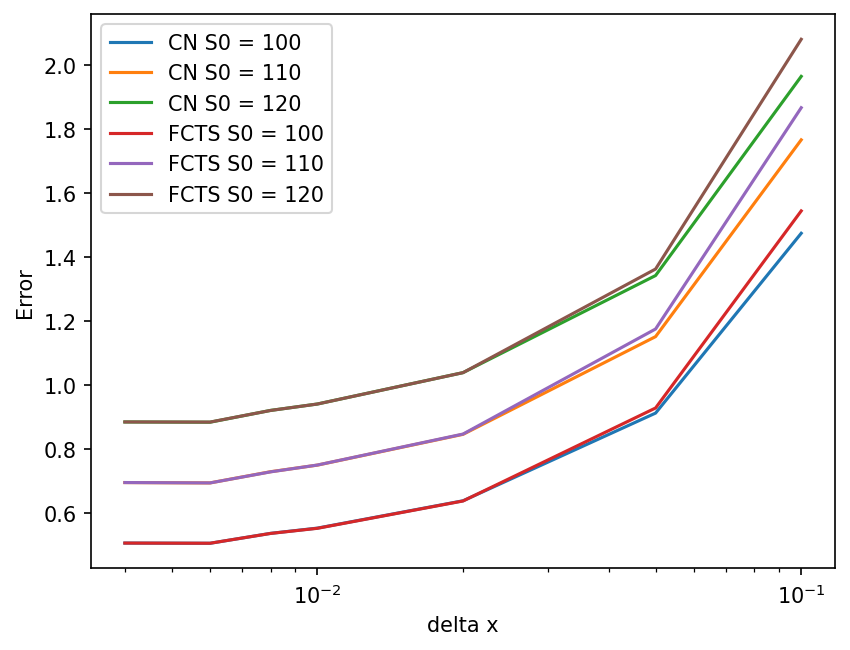

In [36]:
plt.figure(dpi=150)
plt.plot(deltaxs, Error1_C, label = "CN S0 = 100")
plt.plot(deltaxs, Error2_C, label = "CN S0 = 110")
plt.plot(deltaxs, Error3_C, label = "CN S0 = 120")
plt.xscale('log')
plt.xlabel("delta x")
plt.ylabel("Error")
plt.plot(deltaxs, Error1[:-1], label = "FCTS S0 = 100")
plt.plot(deltaxs, Error2[:-1], label = "FCTS S0 = 110")
plt.plot(deltaxs, Error3[:-1], label = "FCTS S0 = 120")
plt.legend()


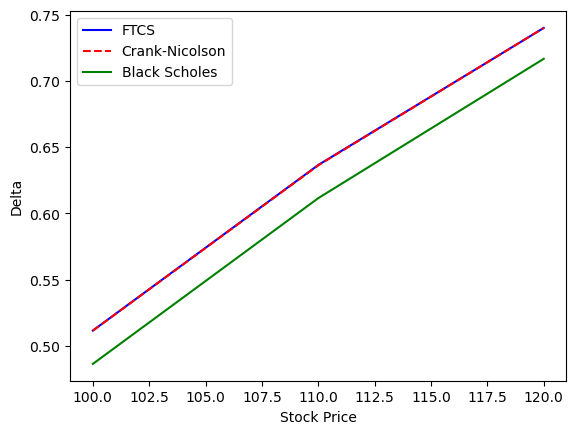

In [65]:
# Option delta

delta_fcts_1 = delta1
delta_fcts_2 = delta_2
delta_fcts_3 = delta_3


# Delta's black scholes
delta_BS = []
for S in S0:
    delta_BS.append(blackScholes(S, K, 0, T, r, sigma, option_type = "call")[1])


# print all delta'set

delta_crank_1, delta_crank_2, delta_crank_3, delta_fcts_1, delta_fcts_2, delta_fcts_3
deltas_crank = delta_crank_1, delta_crank_2, delta_crank_3
deltas_FTCS = delta_fcts_1, delta_fcts_2, delta_fcts_3


plt.plot(S0, deltas_FTCS, color = 'b')
plt.plot(S0, deltas_crank, linestyle = '--', color = 'r')
plt.plot(S0, delta_BS, color = 'g')
plt.xlabel("Stock Price")
plt.ylabel("Delta")
plt.legend(["FTCS", "Crank-Nicolson", "Black Scholes"])
plt.show()


### COS Method

In [57]:
def function_Fn(n, r, b, a, vol, x, T):
    first_term = np.exp(-0.5 * T * (vol * n * np.pi/(b-a))**2)
    sec_term = np.cos((n * np.pi /(b - a)) * (x - a + (r - 0.5 * vol**2) * T))
    return first_term * sec_term

In [58]:
def function_Gn(K, a, b, n):
    chi_prod_term = 1 / (1 + (n * np.pi / (b - a))**2)
    chi_sec =  np.exp(b) * np.cos(n * np.pi) - np.cos(n * np.pi * a /(b - a)) + np.sin(n * np.pi * a / (b - a)) * (n * np.pi / (b - a))
    chi = chi_prod_term * chi_sec
    if n == 0:
        phi = b
    else:
        phi = np.sin(n * np.pi * a / (b - a)) * (b - a) / (n * np.pi)
        
    return (chi - phi) * 2 * K/(b - a)

In [59]:
def option_price_fourier(K, r, vol, T, a, b, N, x):
    option_price = function_Gn(K, a, b, 0) * function_Fn(0, r, b, a, vol, x, T) * 0.5
    for n in range(1, N):
        option_price += function_Gn(K, a, b, n) * function_Fn(n, r, b, a, vol, x, T)
    return option_price * np.exp(-r * T)


In [ ]:
# Scenario 1
S0 = 100
K = 110
x = np.log(S0/K)
vol = 0.3
r = 0.04
a = 0.0 - 7 * np.sqrt(T)
b = 0.0 + 7 * np.sqrt(T)
option_price_fourier(K, r, vol, T, a, b, 64, x)

9.628165602829203

In [ ]:
# Scenario 2
S0 = 110
K = 110
x = np.log(S0/K)
vol = 0.3
r = 0.04
a = 0.0 - 7 * np.sqrt(T)
b = 0.0 + 7 * np.sqrt(T)
option_price_fourier(K, r, vol, T, a, b, 64, x)

15.123992930583412

In [69]:
# Scenario 3
S0 = 120
K = 110
x = np.log(S0/K)
vol = 0.3
r = 0.04
a = 0.0 - 7 * np.sqrt(T)
b = 0.0 + 7 * np.sqrt(T)
option_price_fourier(K, r, vol, T, a, b, 64, x)

21.783607367828346

 ### Truncation error 

In [61]:
N = np.arange(20, 100, 2)
option_price1_cos = []
option_price2_cos = []
option_price3_cos = []
S0 = [100, 110, 120]
K = 110
T = 1.0
r = 0.04
l = 4
sigma = 0.3
for n in tqdm(N):
    y1_Cos = option_price_fourier(K, r, vol, T, -l, l, n , np.log(S0[0]/K))
    y2_Cos = option_price_fourier(K, r, vol, T, -l, l, n , np.log(S0[1]/K))
    y3_Cos = option_price_fourier(K, r, vol, T, -l, l, n , np.log(S0[2]/K))
    option_price1_cos.append(y1_Cos)
    option_price2_cos.append(y2_Cos)
    option_price3_cos.append(y3_Cos)
Error1_Cos = np.abs(np.array(option_price1_cos) - blackScholes(S0[0], K, 0, T, r, sigma, option_type = "call")[0])
Error2_Cos = np.abs(np.array(option_price2_cos) - blackScholes(S0[1], K, 0, T, r, sigma, option_type = "call")[0])
Error3_Cos = np.abs(np.array(option_price3_cos) - blackScholes(S0[2], K, 0, T, r, sigma, option_type = "call")[0])

100%|██████████| 40/40 [00:00<00:00, 1083.64it/s]


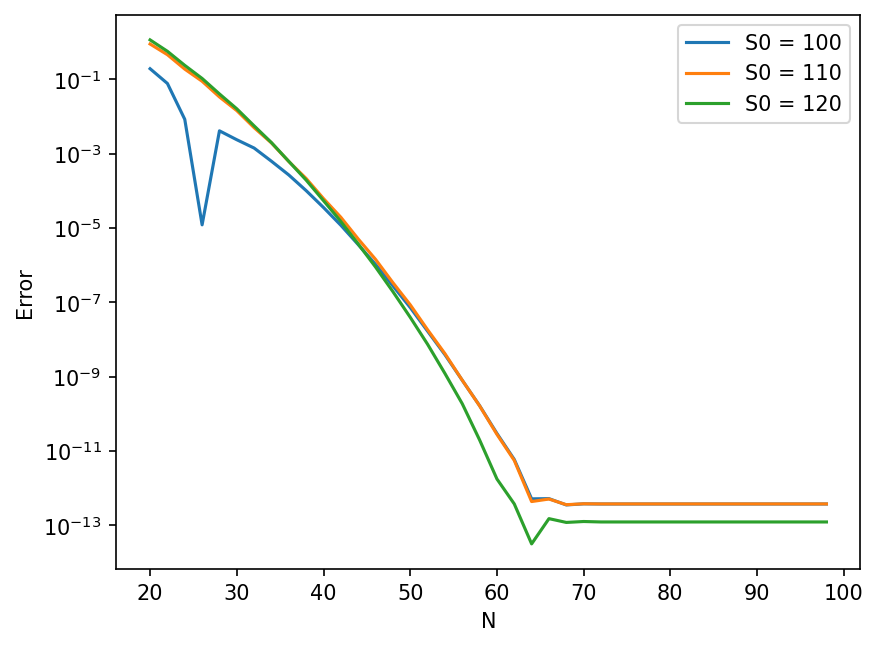

In [62]:
plt.figure(dpi=150)
plt.plot(N, Error1_Cos, label = "S0 = 100")
plt.plot(N, Error2_Cos, label = "S0 = 110")
plt.plot(N, Error3_Cos, label = "S0 = 120")
plt.yscale('log')
plt.xlabel("N")
plt.ylabel("Error")
plt.legend()
plt.savefig("error_cos_N.png")

In [63]:
L = np.arange(1, 9, 1)
option_price1_cos2 = []
option_price2_cos2 = []
option_price3_cos2 = []
S0 = [100, 110, 120]
K = 110
T = 1.0
r = 0.04
sigma = 0.3
N = 64  
for l in tqdm(L):
    y1_Cos2 = option_price_fourier(K, r, vol, T, -l, l, N , np.log(S0[0]/K))
    y2_Cos2 = option_price_fourier(K, r, vol, T, -l, l, N , np.log(S0[1]/K))
    y3_Cos2 = option_price_fourier(K, r, vol, T, -l, l, N , np.log(S0[2]/K))
    option_price1_cos2.append(y1_Cos2)
    option_price2_cos2.append(y2_Cos2)
    option_price3_cos2.append(y3_Cos2)
Error1_Cos2 = np.abs(np.array(option_price1_cos2) - blackScholes(S0[0], K, 0, T, r, sigma, option_type = "call")[0])
Error2_Cos2 = np.abs(np.array(option_price2_cos2) - blackScholes(S0[1], K, 0, T, r, sigma, option_type = "call")[0])
Error3_Cos2 = np.abs(np.array(option_price3_cos2) - blackScholes(S0[2], K, 0, T, r, sigma, option_type = "call")[0])

100%|██████████| 8/8 [00:00<00:00, 444.82it/s]


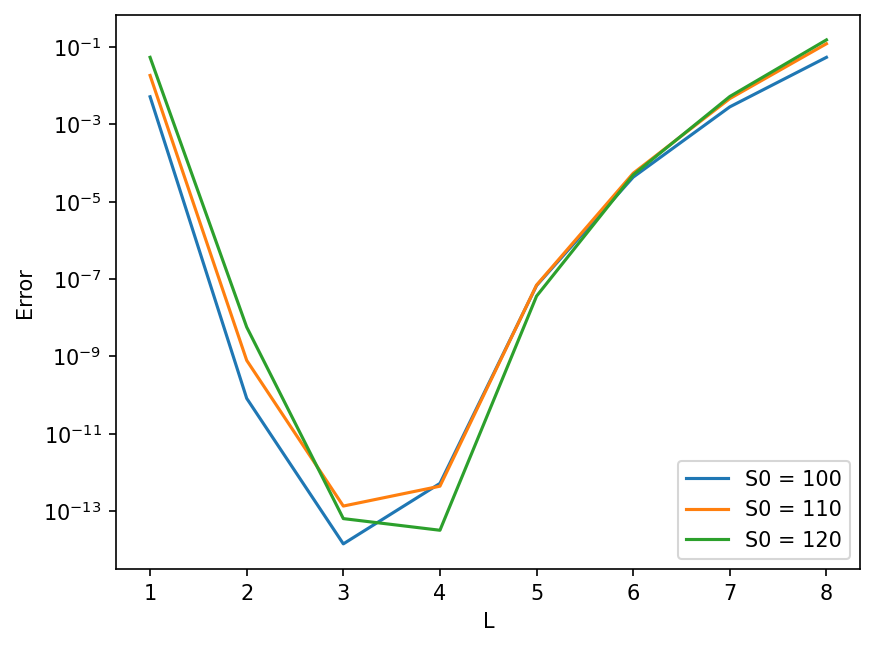

In [64]:
plt.figure(dpi=150) 
plt.plot(L, Error1_Cos2, label = "S0 = 100")
plt.plot(L, Error2_Cos2, label = "S0 = 110")
plt.plot(L, Error3_Cos2, label = "S0 = 120")
plt.yscale('log')
plt.xlabel("L")
plt.ylabel("Error")
plt.legend()
plt.savefig("error_cos_l.png")
plt.show()